# Importing some packages

In [96]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.filterwarnings('ignore')

# Loading data

In [61]:
train_df = pd.read_excel('Train.xlsx')
test_df = pd.read_excel('Test.xlsx')
sub_df = pd.read_csv('Submission.csv')

# EDA

In [62]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59709 entries, 0 to 59708
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             59709 non-null  int64         
 1   St_Hour                59709 non-null  int64         
 2   St_Day                 59709 non-null  int64         
 3   St_Month               59709 non-null  int64         
 4   St_Year                59709 non-null  int64         
 5   User_type              59709 non-null  object        
 6   Datetime               59709 non-null  datetime64[ns]
 7   Rental_Bicycles_Count  59709 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 3.6+ MB


In [63]:
train_df.head()

,Unnamed: 0,St_Hour,St_Day,St_Month,St_Year,User_type,Datetime,Rental_Bicycles_Count
0,0,0,1,1,2013,occasional,2013-01-01 00:00:00,20
1,1,0,1,1,2013,subscribed,2013-01-01 00:00:00,26
2,2,1,1,1,2013,occasional,2013-01-01 01:00:00,23
3,3,1,1,1,2013,subscribed,2013-01-01 01:00:00,23
4,4,2,1,1,2013,occasional,2013-01-01 02:00:00,20


In [64]:
train_df.tail()

,Unnamed: 0,St_Hour,St_Day,St_Month,St_Year,User_type,Datetime,Rental_Bicycles_Count
59704,59704,21,31,5,2016,subscribed,2016-05-31 21:00:00,529
59705,59705,22,31,5,2016,occasional,2016-05-31 22:00:00,298
59706,59706,22,31,5,2016,subscribed,2016-05-31 22:00:00,455
59707,59707,23,31,5,2016,occasional,2016-05-31 23:00:00,292
59708,59708,23,31,5,2016,subscribed,2016-05-31 23:00:00,450


The training data doesn't contain any missing values judging by the tables above.

In [65]:
train_df.duplicated().sum()

0

The output of the above cell confirms that there are no duplicates in the training data.

Let's check whether the difference between all subsequent dates is an hour. If not, then we have missing dates.

In [66]:
for user_type in train_df['User_type'].unique():
    filtered_df = train_df[train_df['User_type']==user_type].sort_values('Datetime', ascending=True).reset_index(drop=True)
    filtered_df['date_diff'] = filtered_df['Datetime'].diff().apply(lambda x: x if pd.isna(x) else x.seconds).to_frame()
    inconsitency_mask = (filtered_df['date_diff'].iloc[1:] != 3600)
    n_inconsistency = inconsitency_mask.sum()
    print(10*"#" + f" {user_type} " + 10*"#")
    print(f"{n_inconsistency} not subsequent dates")
    print('\n')
    print('Dates differences except for hourly')
    print(filtered_df[filtered_df['date_diff'] != 3600]['date_diff'].value_counts())
    print('\n')


########## occasional ##########
89 not subsequent dates


Dates differences except for hourly
date_diff
7200     82
10800     6
14400     1
Name: count, dtype: int64


########## subscribed ##########
43 not subsequent dates


Dates differences except for hourly
date_diff
7200     37
10800     5
14400     1
Name: count, dtype: int64




It turned out that the train data contain data for some dates. Let's find these dates and save in a dictionary.

In [67]:
train_full_dates = pd.date_range(start='2013-01-01', end='2016-06-01', freq='60min')[:-1]
train_full_dates

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 01:00:00',
               '2013-01-01 02:00:00', '2013-01-01 03:00:00',
               '2013-01-01 04:00:00', '2013-01-01 05:00:00',
               '2013-01-01 06:00:00', '2013-01-01 07:00:00',
               '2013-01-01 08:00:00', '2013-01-01 09:00:00',
               ...
               '2016-05-31 14:00:00', '2016-05-31 15:00:00',
               '2016-05-31 16:00:00', '2016-05-31 17:00:00',
               '2016-05-31 18:00:00', '2016-05-31 19:00:00',
               '2016-05-31 20:00:00', '2016-05-31 21:00:00',
               '2016-05-31 22:00:00', '2016-05-31 23:00:00'],
              dtype='datetime64[ns]', length=29928, freq='60min')

In [68]:
missing_dates_dict = {}
for user_type in train_df['User_type'].unique():
    train_date = train_df[train_df['User_type']==user_type]['Datetime'].tolist()
    missing_dates = [i for i in train_full_dates if i not in train_date]
    missing_dates_dict[user_type] = missing_dates
    print(f"{user_type}: {len(missing_dates)} missing dates")

occasional: 97 missing dates
subscribed: 50 missing dates


In [69]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  1440 non-null   int64         
 1   St_Hour     1440 non-null   int64         
 2   St_Day      1440 non-null   int64         
 3   St_Month    1440 non-null   int64         
 4   St_Year     1440 non-null   int64         
 5   User_type   1440 non-null   object        
 6   Datetime    1440 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 78.9+ KB


In [70]:
test_df.head()

,Unnamed: 0,St_Hour,St_Day,St_Month,St_Year,User_type,Datetime
0,0,0,1,6,2016,occasional,2016-06-01 00:00:00
1,1,0,1,6,2016,subscribed,2016-06-01 00:00:00
2,2,1,1,6,2016,occasional,2016-06-01 01:00:00
3,3,1,1,6,2016,subscribed,2016-06-01 01:00:00
4,4,2,1,6,2016,occasional,2016-06-01 02:00:00


Checking whether the difference between all subsequent dates is an hour in the test set.

In [71]:
for user_type in test_df['User_type'].unique():
    filtered_df = test_df[test_df['User_type']==user_type].sort_values('Datetime', ascending=True).reset_index(drop=True)
    filtered_df['date_diff'] = filtered_df['Datetime'].diff().apply(lambda x: x if pd.isna(x) else x.seconds).to_frame()
    inconsitency_mask = (filtered_df['date_diff'].iloc[1:] != 3600)
    n_inconsistency = inconsitency_mask.sum()
    print(10*"#" + f" {user_type} " + 10*"#")
    print(f"{n_inconsistency} not subsequent dates")
    print('\n')
    print('Dates differences except for hourly')
    print(filtered_df[filtered_df['date_diff'] != 3600]['date_diff'].value_counts())
    print('\n')


########## occasional ##########
0 not subsequent dates


Dates differences except for hourly
Series([], Name: count, dtype: int64)


########## subscribed ##########
0 not subsequent dates


Dates differences except for hourly
Series([], Name: count, dtype: int64)




In [72]:
sub_df.head()

,Rental_Bicycles_Count
0,0
1,0
2,0
3,0
4,0


## Univariate analysis

### Categorical data

In [73]:
train_df['User_type'].value_counts()

User_type
subscribed    29878
occasional    29831
Name: count, dtype: int64

In [74]:
test_df['User_type'].value_counts()

User_type
occasional    720
subscribed    720
Name: count, dtype: int64

## Bivariate analysis

### Target per User Type

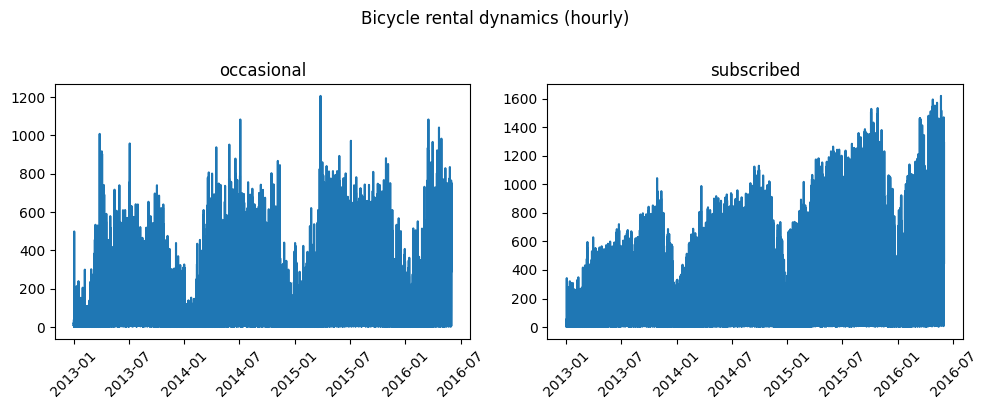

In [75]:
plot_idx = 0

plt.figure(figsize=(10, 4))

for user_type in train_df['User_type'].unique():

    plot_idx += 1

    plt.subplot(1, 2, plot_idx)
    plt.plot(
        train_df[train_df['User_type']==user_type]['Datetime'], 
        train_df[train_df['User_type']==user_type]['Rental_Bicycles_Count']
    )
    plt.title(f"{user_type}")
    plt.xticks(rotation=45)

plt.suptitle('Bicycle rental dynamics (hourly)', y=1.01)
plt.tight_layout()

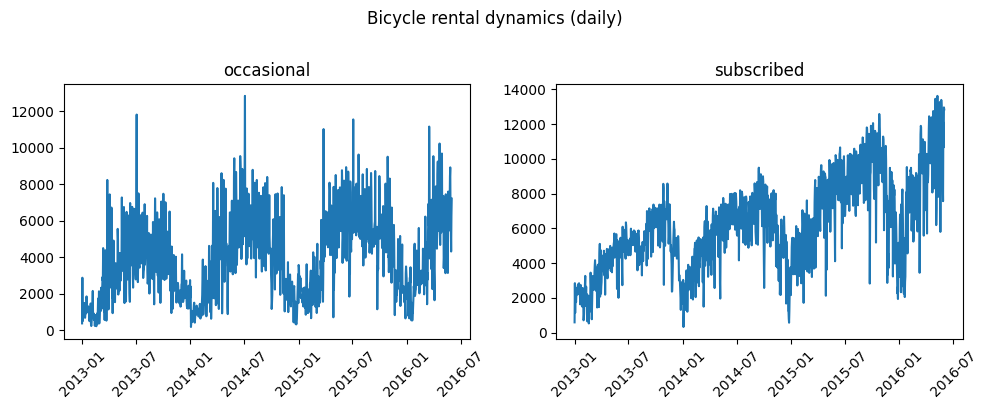

In [76]:
plot_idx = 0

plt.figure(figsize=(10, 4))

for user_type in train_df['User_type'].unique():

    temp_df = train_df[train_df['User_type']==user_type].set_index('Datetime').resample('D').sum()
    temp_df.reset_index(inplace=True)

    plot_idx += 1

    plt.subplot(1, 2, plot_idx)
    plt.plot(
        temp_df['Datetime'], 
        temp_df['Rental_Bicycles_Count']
    )
    plt.title(f"{user_type}")
    plt.xticks(rotation=45)

plt.suptitle('Bicycle rental dynamics (daily)', y=1.01)
plt.tight_layout()

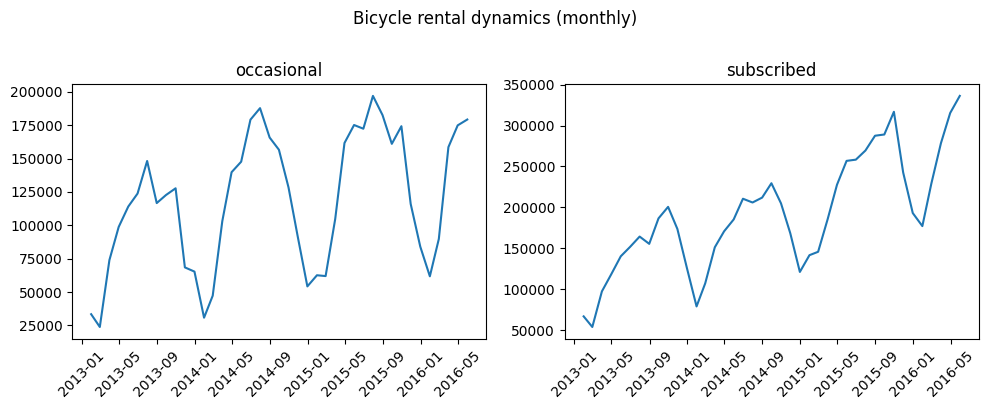

In [77]:
plot_idx = 0

plt.figure(figsize=(10, 4))

for user_type in train_df['User_type'].unique():

    temp_df = train_df[train_df['User_type']==user_type].set_index('Datetime').resample('ME').sum()
    temp_df.reset_index(inplace=True)

    plot_idx += 1

    plt.subplot(1, 2, plot_idx)
    plt.plot(
        temp_df['Datetime'], 
        temp_df['Rental_Bicycles_Count']
    )
    plt.title(f"{user_type}")
    plt.xticks(rotation=45)

plt.suptitle('Bicycle rental dynamics (monthly)', y=1.01)
plt.tight_layout()

The charts above show that there are seasonality pattern present in bicycles' rental quantity. But, in case of subscribed user, we observe more visible increasing trend. Though there is a neglible trend in occasional users' rentals too. It seems that subscribed users' rental data can be modeled by multiplicative time series model and occasional users' data by additive time series model in some sense.

### Target hourly dynamics per day by user type

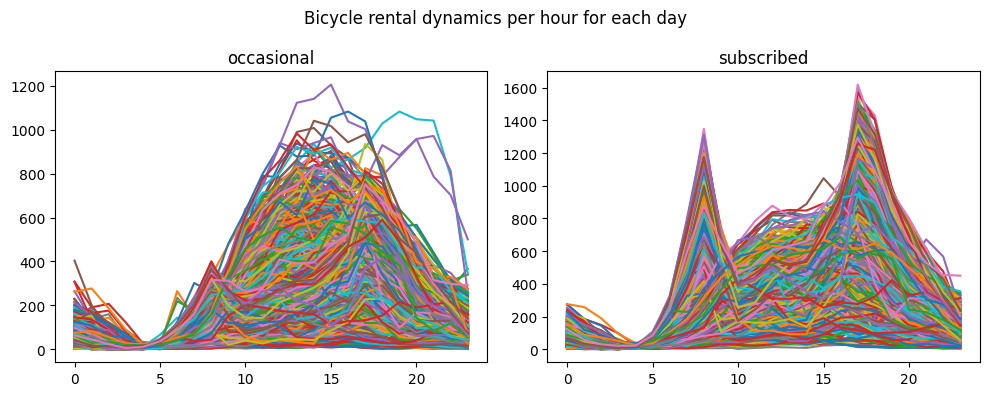

In [78]:
train_df['date'] = train_df['Datetime'].dt.date

plot_idx = 0

plt.figure(figsize=(10, 4))

for user_type in train_df['User_type'].unique():

    plot_idx += 1

    temp_df = train_df[train_df['User_type']==user_type]

    for i_date in train_df['date'].unique():

        temp_df2 = temp_df[temp_df['date']==i_date]

        plt.subplot(1, 2, plot_idx)
        plt.plot(temp_df2['St_Hour'], temp_df2['Rental_Bicycles_Count'])

    plt.title(f"{user_type}")

plt.suptitle("Bicycle rental dynamics per hour for each day")
plt.tight_layout()

From the charts above we observe some patterns in bycicles' rentals per hour.

### Target dynamics per day for each week by user type

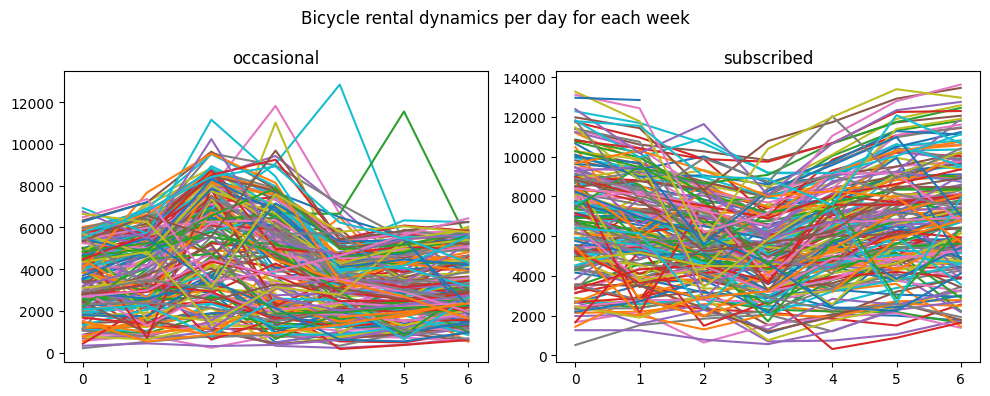

In [79]:
train_df['weekday'] = train_df['Datetime'].dt.weekday
train_df['week'] = train_df['Datetime'].apply(lambda x: x.isocalendar()[1])

year_week_day_grouped_df = train_df.groupby(['St_Year', 'week', 'weekday', 'User_type'], as_index=False)['Rental_Bicycles_Count'].sum()

plot_idx = 0

plt.figure(figsize=(10, 4))

for user_type in year_week_day_grouped_df['User_type'].unique():
    plot_idx += 1
    year_week_day_grouped_df2 = year_week_day_grouped_df[year_week_day_grouped_df['User_type']==user_type]
    for year in year_week_day_grouped_df2['St_Year'].unique():
        for week in year_week_day_grouped_df2['week'].unique():
            
            year_week_day_grouped_df3 = year_week_day_grouped_df2[
                (year_week_day_grouped_df2['St_Year']==year) & (year_week_day_grouped_df2['week']==week)
            ]

            plt.subplot(1, 2, plot_idx)
            plt.plot(year_week_day_grouped_df3['weekday'], year_week_day_grouped_df3['Rental_Bicycles_Count'])

    plt.title(f"{user_type}")

plt.suptitle("Bicycle rental dynamics per day for each week")
plt.tight_layout()
         

From the charts above we observe some patterns in bycicles' rentals per week day.

### Target dynamics per week for each year by user type

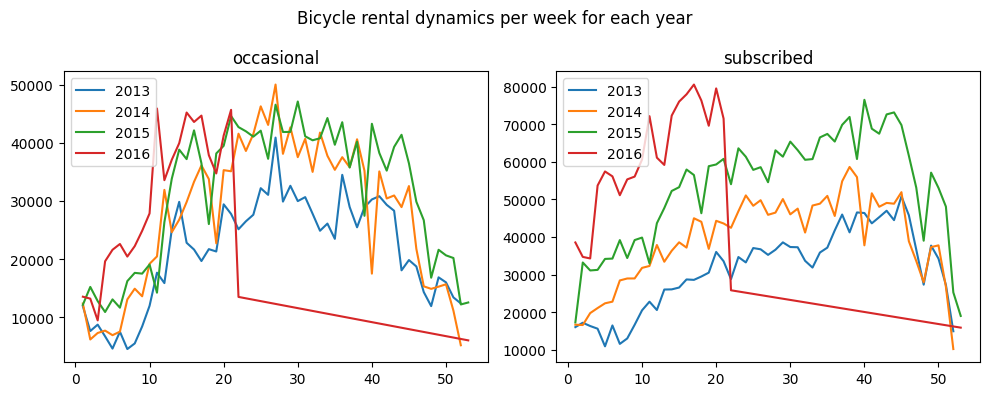

In [80]:
train_df['week'] = train_df['week'].apply(int)

year_week_grouped_df = train_df.groupby(['St_Year', 'week', 'User_type'], as_index=False)['Rental_Bicycles_Count'].sum()

plot_idx = 0

plt.figure(figsize=(10, 4))

for user_type in year_week_grouped_df['User_type'].unique():
    plot_idx += 1
    year_week_grouped_df2 = year_week_grouped_df[year_week_grouped_df['User_type']==user_type]
    for year in year_week_grouped_df2['St_Year'].unique():
            
        year_week_grouped_df3 = year_week_grouped_df2[
            (year_week_grouped_df2['St_Year']==year)
        ]

        plt.subplot(1, 2, plot_idx)
        plt.plot(year_week_grouped_df3['week'], year_week_grouped_df3['Rental_Bicycles_Count'], label=year)

    plt.title(f"{user_type}")
    plt.legend()

plt.suptitle("Bicycle rental dynamics per week for each year")
plt.tight_layout()
         

From the charts above we observe some patterns in bycicles' rentals per week.

### Target dynamics per month for each year by user type

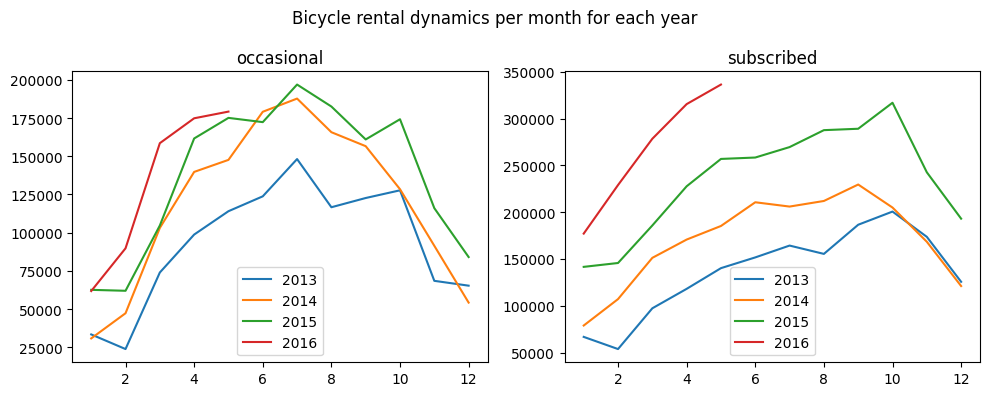

In [81]:
year_month_grouped_df = train_df.groupby(['St_Year', 'St_Month', 'User_type'], as_index=False)['Rental_Bicycles_Count'].sum()

plot_idx = 0

plt.figure(figsize=(10, 4))

for user_type in year_month_grouped_df['User_type'].unique():
    plot_idx += 1
    year_month_grouped_df2 = year_month_grouped_df[year_month_grouped_df['User_type']==user_type]
    for year in year_month_grouped_df2['St_Year'].unique():
            
        year_month_grouped_df3 = year_month_grouped_df2[
            (year_month_grouped_df2['St_Year']==year)
        ]

        plt.subplot(1, 2, plot_idx)
        plt.plot(year_month_grouped_df3['St_Month'], year_month_grouped_df3['Rental_Bicycles_Count'], label=year)

    plt.title(f"{user_type}")
    plt.legend()

plt.suptitle("Bicycle rental dynamics per month for each year")
plt.tight_layout()
         

From the charts above we observe some patterns in bycicles' rentals per month.

### Target dynamics per day for each year by user type

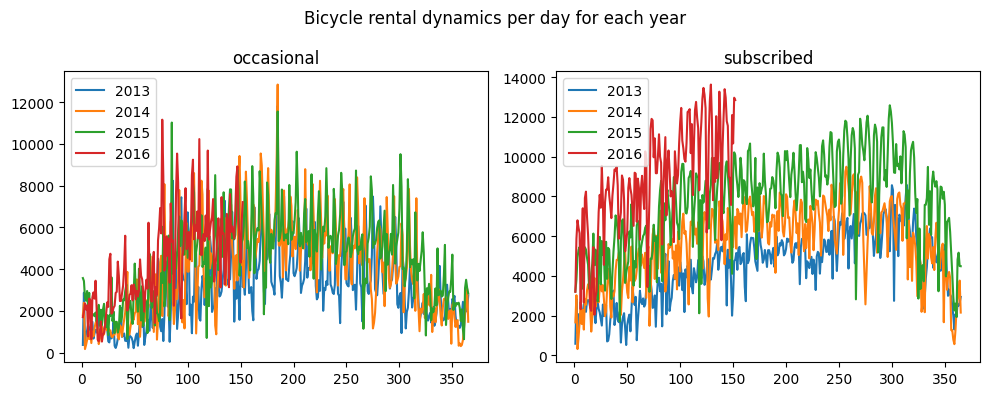

In [82]:
train_df['dayofyear'] = train_df['Datetime'].dt.dayofyear

year_day_grouped_df = train_df.groupby(['St_Year', 'dayofyear', 'User_type'], as_index=False)['Rental_Bicycles_Count'].sum()

plot_idx = 0

plt.figure(figsize=(10, 4))

for user_type in year_day_grouped_df['User_type'].unique():
    plot_idx += 1
    year_day_grouped_df2 = year_day_grouped_df[year_day_grouped_df['User_type']==user_type]
    for year in year_day_grouped_df2['St_Year'].unique():
            
        year_day_grouped_df3 = year_day_grouped_df2[
            (year_day_grouped_df2['St_Year']==year)
        ]

        plt.subplot(1, 2, plot_idx)
        plt.plot(year_day_grouped_df3['dayofyear'], year_day_grouped_df3['Rental_Bicycles_Count'], label=year)

    plt.title(f"{user_type}")
    plt.legend()

plt.suptitle("Bicycle rental dynamics per day for each year")
plt.tight_layout()
         

From the charts above we observe some patterns in bycicles' rentals per day.

### Target dynamics per day for each month by user type

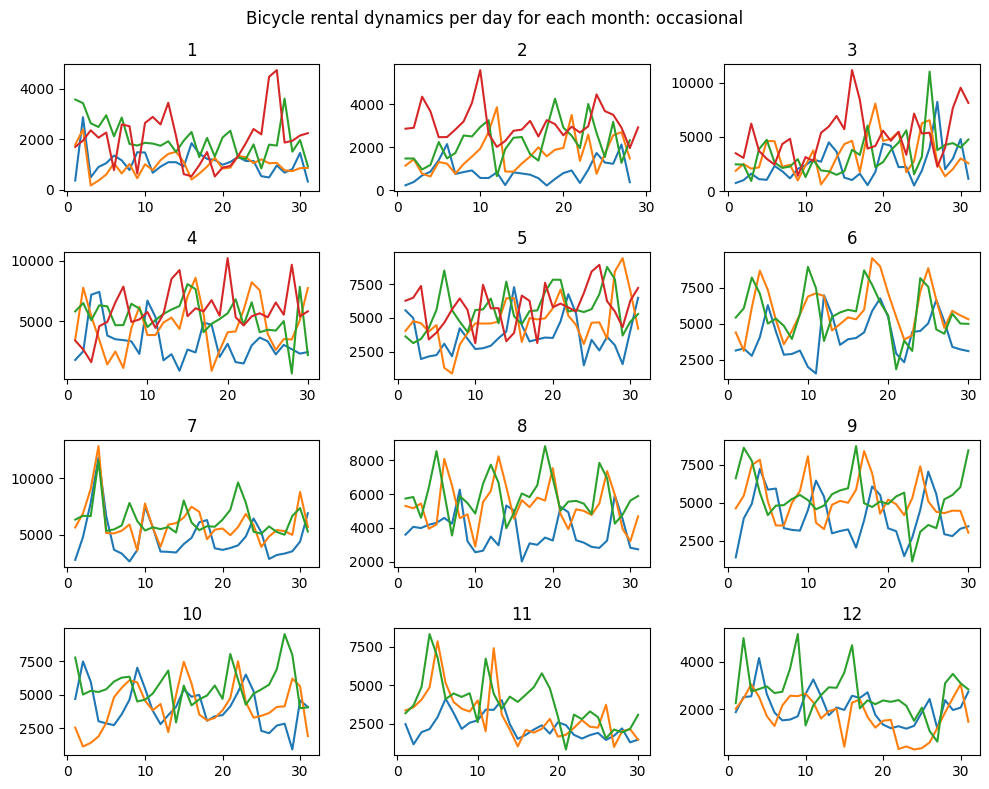

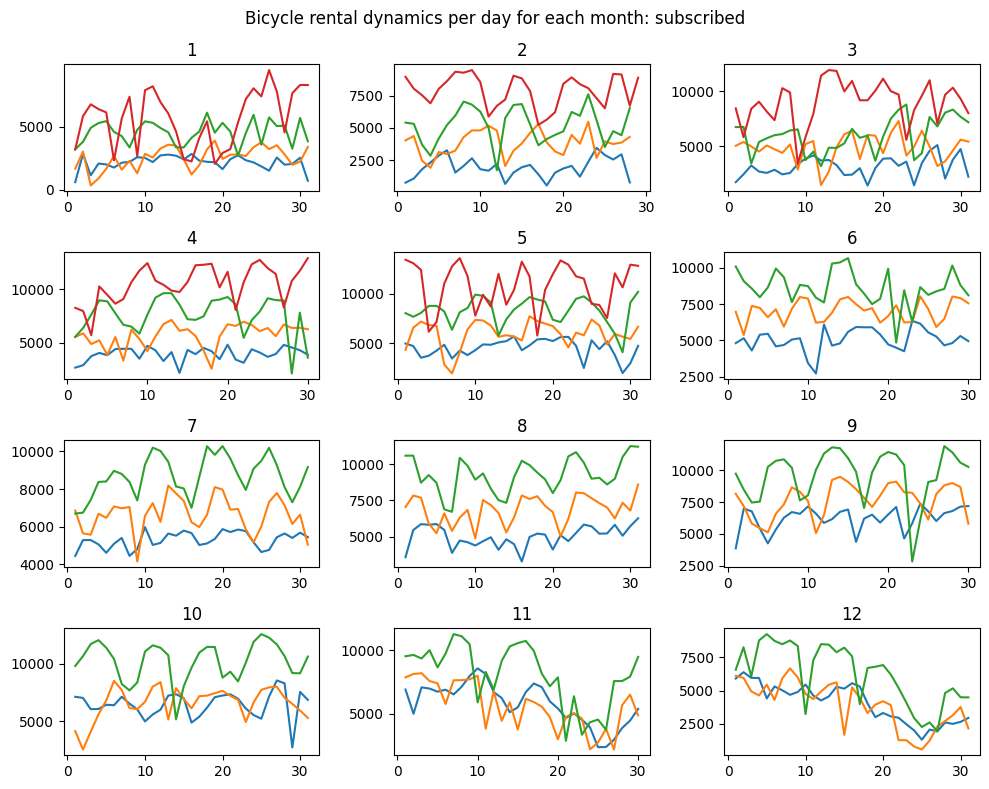

In [83]:
year_month_day_grouped_df = train_df.groupby(['St_Year', 'St_Month', 'St_Day', 'User_type'], as_index=False)['Rental_Bicycles_Count'].sum()

for user_type in year_month_day_grouped_df['User_type'].unique():

    plt.figure(figsize=(10, 8))

    plot_idx = 0
    year_month_day_grouped_df2 = year_month_day_grouped_df[year_month_day_grouped_df['User_type']==user_type]

    for month in year_month_day_grouped_df2['St_Month'].unique():

        plot_idx += 1

        for year in year_month_day_grouped_df2['St_Year'].unique():
            
            year_month_day_grouped_df3 = year_month_day_grouped_df2[
                (year_month_day_grouped_df2['St_Year']==year) & (year_month_day_grouped_df2['St_Month']==month)
            ]

            plt.subplot(4, 3, plot_idx)
            plt.plot(year_month_day_grouped_df3['St_Day'], year_month_day_grouped_df3['Rental_Bicycles_Count'])

        plt.title(f"{month}")

    plt.suptitle(f"Bicycle rental dynamics per day for each month: {user_type}")
    plt.tight_layout()
         

Though the charts above don't show clear patterns in bycicles' rentals per day, it is worth to incorporate this kind of relationship in the features to see whether it will improve the results or not.

### Target hourly distribution per month

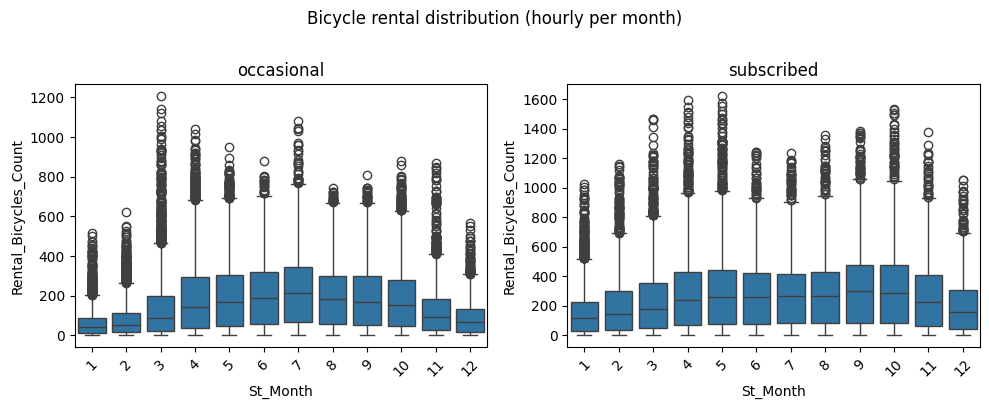

In [84]:
plot_idx = 0

plt.figure(figsize=(10, 4))

for user_type in train_df['User_type'].unique():

    plot_idx += 1

    plt.subplot(1, 2, plot_idx)
    sns.boxplot(x='St_Month', y='Rental_Bicycles_Count', data=train_df[train_df['User_type']==user_type]);
    plt.title(f"{user_type}")
    plt.xticks(rotation=45)

plt.suptitle('Bicycle rental distribution (hourly per month)', y=1.01)
plt.tight_layout()

The plot above shows that the rentals' distribution differs by month. Moreover there are some outliers for each month.

### Target hourly distribution per hour

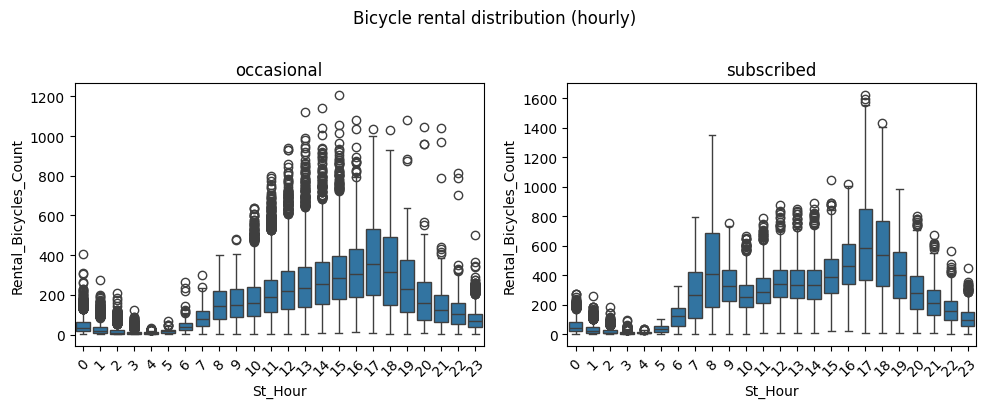

In [85]:
plot_idx = 0

plt.figure(figsize=(10, 4))

for user_type in train_df['User_type'].unique():

    plot_idx += 1

    plt.subplot(1, 2, plot_idx)
    sns.boxplot(x='St_Hour', y='Rental_Bicycles_Count', data=train_df[train_df['User_type']==user_type]);
    plt.title(f"{user_type}")
    plt.xticks(rotation=45)

plt.suptitle('Bicycle rental distribution (hourly)', y=1.01)
plt.tight_layout()

The plot above shows that the rentals' distribution differs by hour. Moreover there are some outliers for each hour.

### Target hourly distribution per day

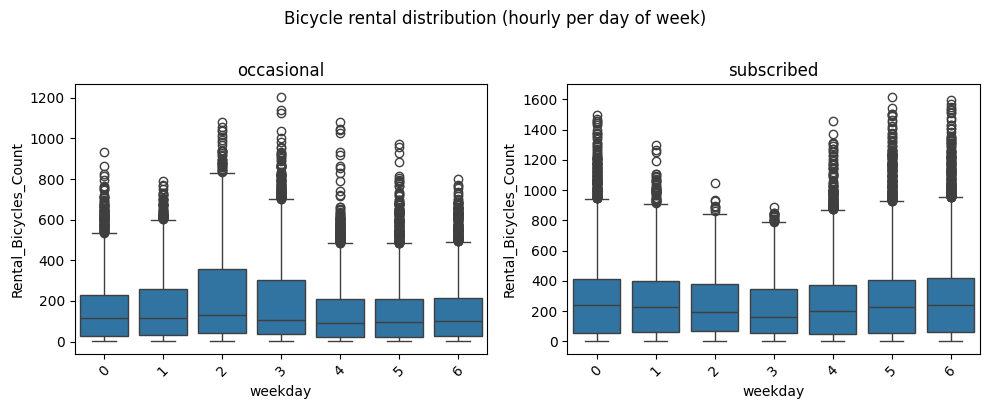

In [86]:
plot_idx = 0

plt.figure(figsize=(10, 4))

for user_type in train_df['User_type'].unique():

    plot_idx += 1

    plt.subplot(1, 2, plot_idx)
    sns.boxplot(x='weekday', y='Rental_Bicycles_Count', data=train_df[train_df['User_type']==user_type]);
    plt.title(f"{user_type}")
    plt.xticks(rotation=45)

plt.suptitle('Bicycle rental distribution (hourly per day of week)', y=1.01)
plt.tight_layout()

The plot above shows that the rentals' distribution differs by day of week. Moreover there are some outliers for each day of week.

### Target and its lag

Now let's return to the caudules dataset. For time series it is important to look at partial autocorrelation plot which shows correlation of a time series current value with its lag value. The x axis of the plot shows the lag steps. The dots on the plot allow to find the autocorrelation corresponding to a lag. If a dot is out of the blue range then we can consider that the lag corresponding to that dot is important for the series. Therefore we need to include the lag value of the series in the features' list. So let's plot the partial autocorrelation for the target by user_type.

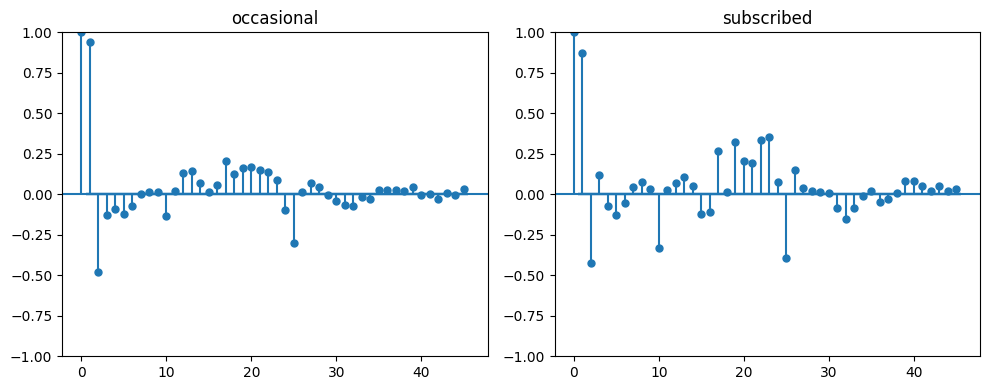

In [91]:
subplot_idx = 0

fig = plt.figure(figsize=(10, 4))

for user_type in train_df['User_type'].unique():
    temp_df = train_df[train_df['User_type']==user_type]
    subplot_idx += 1
    ax_subplot = plt.subplot(1, 2, subplot_idx)
    plot_pacf(temp_df['Rental_Bicycles_Count'], ax=ax_subplot, title=user_type)

plt.tight_layout()

Maybe there is non-linear relationship between current values and lag values. In this case we can plot current values on y axis and the lag values on the x axis to see whether there is any relashionship between them. Let's use 1-10 lags to plot such charts for each user type.

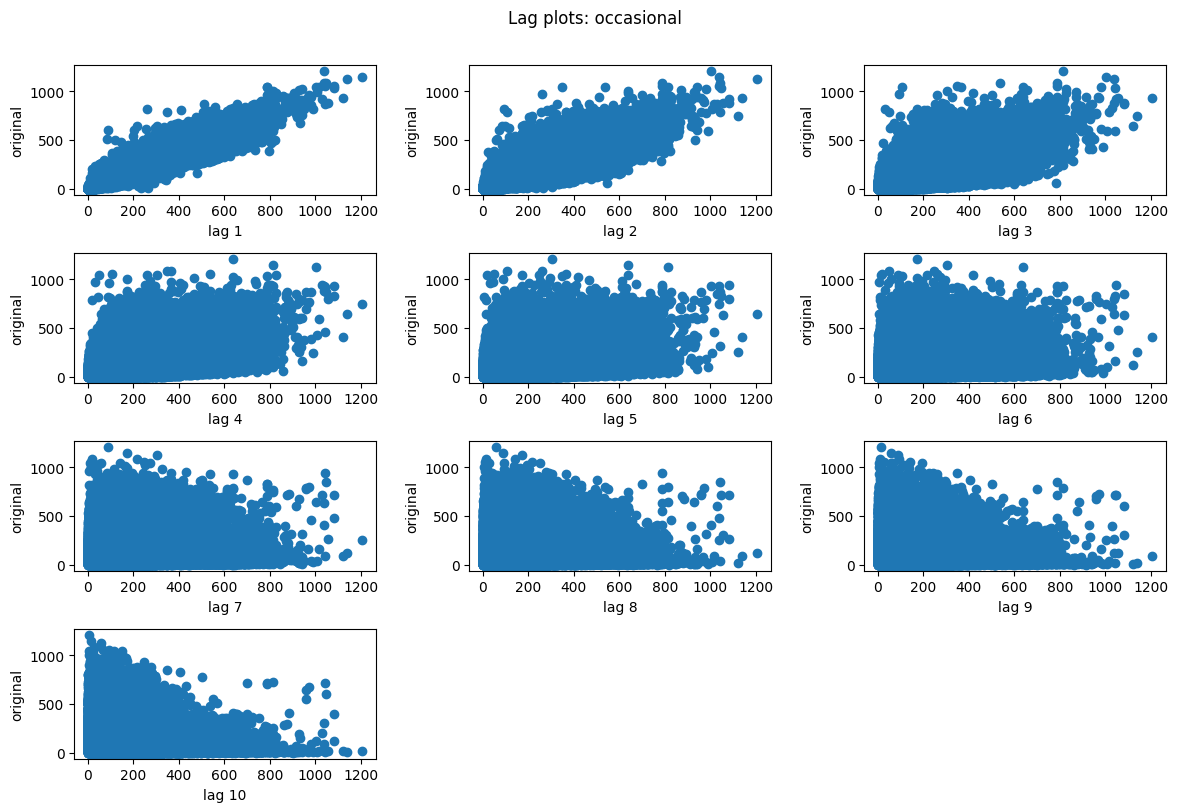

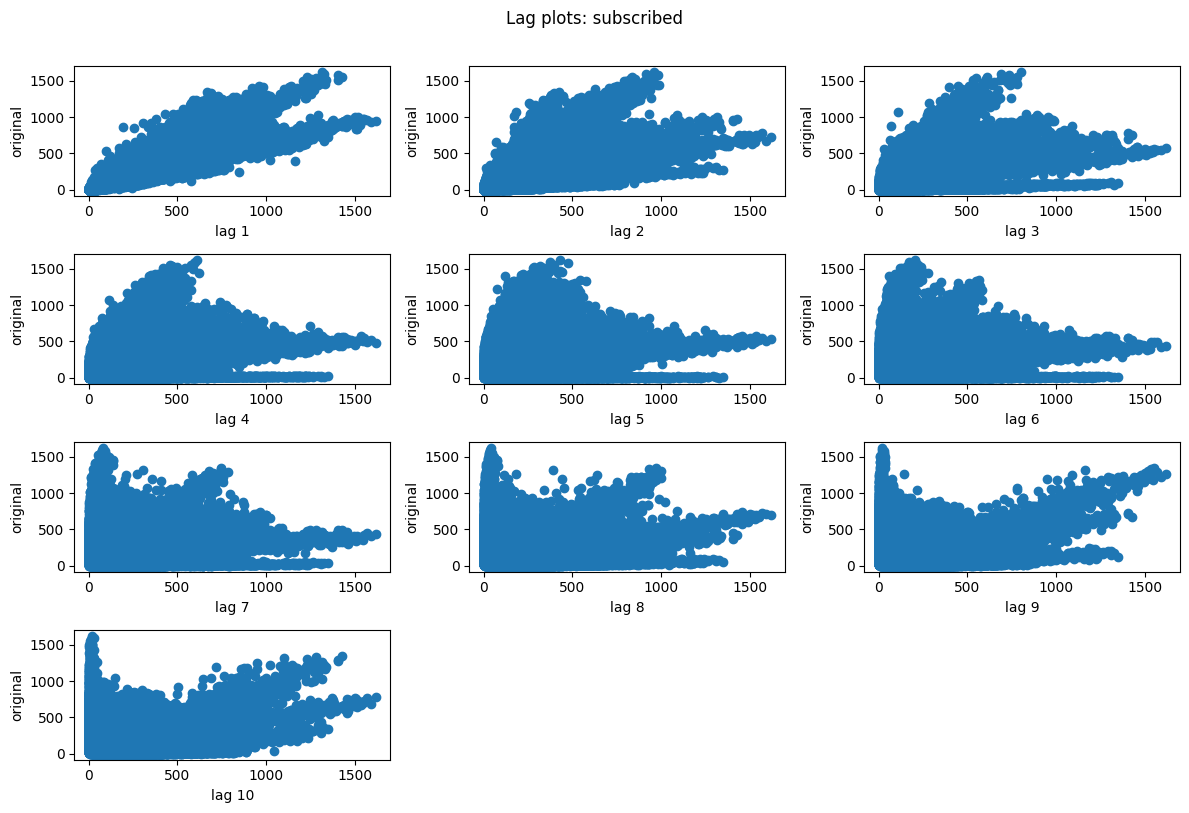

In [97]:
for user_type in train_df['User_type'].unique():

    fig = plt.figure(figsize=(12, 8))

    subplot_idx = 0

    temp_df = train_df[train_df['User_type']==user_type]

    for i in range(1, 11):

        temp_df[f'lag{i}_Rental_Bicycles_Count'] = temp_df['Rental_Bicycles_Count'].shift(i)

        subplot_idx += 1

        plt.subplot(4, 3, subplot_idx)

        plt.scatter(temp_df['Rental_Bicycles_Count'], temp_df[f'lag{i}_Rental_Bicycles_Count'])
        plt.xlabel(f"lag {i}")
        plt.ylabel('original')
        plt.suptitle(f"Lag plots: {user_type}", y=1.01)

    plt.tight_layout()

The lag plots and autocorrelation plot show that lag values of the target can be used as a feature.